In [ ]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler


df = pd.read_csv('BTC-USD.csv')
df = df.sort_values('Date')
df.head()
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()


high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

train_data = mid_prices[:2000]
test_data = mid_prices[2000:]
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)


smoothing_window_size = 250
for di in range(0,1000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)
EMA = 0.0
gamma = 0.1
for ti in range(1100):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)


window_size = 1
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))




plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()



coinBTC-USD


Epoch 1/5
1399/1399 [==============================] - 27s 18ms/step - loss: 2.8489e-04 - accuracy: 0.0000e+00
Epoch 2/5
1399/1399 [==============================] - 25s 18ms/step - loss: 1.3845e-04 - accuracy: 0.0000e+00
Epoch 3/5
1399/1399 [==============================] - 24s 17ms/step - loss: 1.0712e-04 - accuracy: 0.0000e+00
Epoch 4/5
1399/1399 [==============================] - 24s 17ms/step - loss: 8.0873e-05 - accuracy: 0.0000e+00
Epoch 5/5
1399/1399 [==============================] - 24s 17ms/step - loss: 7.4010e-05 - accuracy: 0.0000e+00


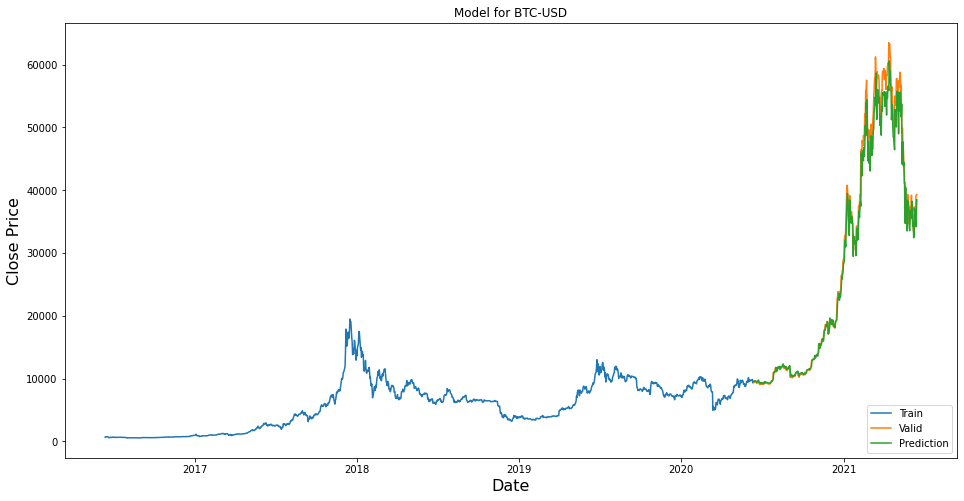

                   Close   Predictions
Date                                  
2020-06-12   9475.277344   9607.479492
2020-06-13   9386.788086   9624.471680
2020-06-14   9450.702148   9542.171875
2020-06-15   9538.024414   9589.998047
2020-06-16   9480.254883   9670.584961
...                  ...           ...
2021-06-09  36702.597656  37102.597656
2021-06-10  37334.398438  35616.882812
2021-06-11  35552.515625  36276.351562
2021-06-12  39097.859375  34179.851562
2021-06-14  39344.605469  38505.761719

[364 rows x 2 columns]
The accuracy of the LSTM Model predicting the movement of a stock each day is 44.6%
     Valid Movement  Predicted Movement
0                 1                   0
1                 0                   1
2                 0                   0
3                 1                   0
4                 1                   1
..              ...                 ...
358               1                   0
359               0                   1
360               1      

In [1]:
#import the libraries
import math
import warnings
import datetime 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from pandas_datareader import DataReader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, LSTM

warnings.filterwarnings("ignore")

#get the stock quote for the past 5 years
stock = input("coin")
num_of_years = 5
start_date = datetime.datetime.now() - datetime.timedelta(days=int(365.25*num_of_years))
end_date = datetime.date.today()

df = DataReader(stock, "yahoo", start_date, end_date)
data = df.filter(['Close'])
dataset = data.values
train_data_len = math.ceil(len(dataset)*.8)

#scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

#create the training dataset
train_data = scaled_data[0:train_data_len, :]

#split the data into x_train and y_train dataset
x_train=[]
y_train=[]

for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i<=61:
    #print(x_train)
    #print(y_train)
    print()

#convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#reshape the data to 3 dimension
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

#build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))

model.add(Dense(25))
model.add(Dense(1))

#compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

#train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

#create test dataset
test_data = scaled_data[train_data_len-60:, :]

#create dataset x_test, y_test
x_test = []
y_test = dataset[train_data_len:, :]
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i, 0])

#convert data to numpy array
x_test = np.array(x_test)

#reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

#get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((predictions-y_test)**2))

#plot the data
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model for {}'.format(stock.upper()))
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price', fontsize=16)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Valid','Prediction'],loc='lower right')
plt.show()

print (valid)

# find the accuracy based on predicting day-to-day movements 
valid_movement = []
pred_movement = []
close_prices = valid.Close.tolist()
pred_prices = valid.Predictions.tolist()
        
n = 0

for index, value in enumerate(close_prices[:-1]):
    if value > close_prices[index+1]: 
        valid_movement.append(1)
    else:
        valid_movement.append(0)

for index, value in enumerate(pred_prices[:-1]):
    if value > pred_prices[index+1]: 
        pred_movement.append(1)
    else:
        pred_movement.append(0)

for val, pred in zip(valid_movement, pred_movement):
    if val == pred:
        n=n+1
    else:
        pass

total = len(valid_movement)
accuracy = n/total
print (f'The accuracy of the LSTM Model predicting the movement of a stock each day is {100 * round(accuracy, 3)}%')

dataframe = pd.DataFrame(list(zip(valid_movement, pred_movement)), columns =['Valid Movement', 'Predicted Movement'])
print (dataframe)

#get predicted price for next day
last_60day = data[-60:].values
last_60day_scaled = scaler.transform(last_60day)
xx_test = []
xx_test.append(last_60day_scaled)
xx_test = np.array(xx_test)
xx_test = np.reshape(xx_test, (xx_test.shape[0], xx_test.shape[1],1))
i=0
for i in range(10):
    pred = model.predict(xx_test)
    pred = scaler.inverse_transform(pred)
    pred = pred[0]
    pred = pred[0]
    print("The predicted price for the next trading day is: {}".format(round(pred, 2)))

#get stats
#Root mean squared error 
print (f'The root mean squared error is {round(rmse, 2)}')

error = mean_squared_error(valid['Close'].tolist(), valid['Predictions'].tolist())
print('Testing Mean Squared Error: %.3f' % error)


In [ ]:
# Importing the libraries
import math
import datetime
import warnings
import numpy as np
from math import sqrt
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from pandas.plotting import lag_plot
from tensorflow.keras.layers import Dense, LSTM
from pandas_datareader import DataReader
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

ticker = 'XRP-USD'
start_date = datetime.datetime.now() - datetime.timedelta(days=365)
end_date = datetime.date.today()

# # Fetching the historic prices 
df = DataReader(ticker, 'yahoo', start_date, end_date)

# # Plotting the data
plt.figure(figsize=(16,8))
plt.title(f'{ticker} Close Price History')
plt.plot(df['Close'],linewidth=2)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

last= df.tail(365)
plt.figure(figsize=(16,8))
plt.title(f"{ticker}'s Daily Returns")
returns = last['Close'] / last['Close'].shift(1) - 1
returns.plot(label='returns %',linewidth=1)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Returns (%)', fontsize=18)
plt.legend(loc='upper left')

mavg50 = df['Close'].rolling(window=50).mean()
mavg200 = df['Close'].rolling(window=20).mean()
mpl.rc('figure', figsize=(16,8))

df['Close'].plot(label=f'{ticker}',linewidth=1)
mavg50.plot(label='50 day moving average',linewidth=1)
mavg200.plot(label='200 day moving average',linewidth=1)
plt.legend(loc='upper left')
plt.title(f"{ticker} - 50 vs 200 day Moving Average")


# # LSTM Model Building
#Create a new dataframe with only the 'Close column
data = df.filter(['Close'])
dataset = data.values

#Using 80% of the data as traning data
training_data_len = math.ceil( len(dataset) * .8 )

#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

#Create the training data set
train_data = scaled_data[0:training_data_len , :]

#Split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

#Creating numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

#Creating the Neural Network - LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=5, epochs=5)

#Creating the test set
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

#Get predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

#Root mean squared error 
rmse=sqrt(mean_squared_error(predictions, y_test))
print ('\n')
print (f'The root mean squared error is {rmse}')

#Plot the data
train = data[900:training_data_len]
valid = data[training_data_len:]

valid['Predictions'] = predictions
plt.figure(figsize=(24,10))
plt.title(f'{ticker} Actual vs Predicted Prices')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price USD ($)', fontsize=15)
plt.plot(train['Close'],linewidth=1)
plt.plot(valid[['Close', 'Predictions']],linewidth=1.5)
plt.legend(['Historic Prices', 'Actual Prices', 'Predicted Prices'], loc='lower right')
plt.show()

#Creating a loop that checks if the prices have increased or decreased day vs. day+1 and seeing if actual vs predicted was correct
valid['Actual']= ''
valid['Predicted']= ''
valid['Recommendation']= ''

for i in range(0,len(valid)-1):
    if valid['Close'][i]<valid['Close'][i+1]:
        valid['Actual'][i+1]= "Increase"
    else:
        valid['Actual'][i+1]= "Decrease"
    if valid['Predictions'][i]<valid['Predictions'][i+1]:
        valid['Predicted'][i+1]= "Increase"
    else:
        valid['Predicted'][i+1]= "Decrease" 

for i in range(1,len (valid)):
    if valid['Actual'][i] == valid['Predicted'][i]:
        valid['Recommendation'][i]= "Correct"
    else:
        valid['Recommendation'][i]= "Incorrect"      

print(valid.tail(10))

# # Autocorrelation
plt.figure(figsize=(10,10))
lag_plot(df['Close'], lag=5)
plt.title(f'{ticker} Autocorrelation plot')

train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
plt.figure(figsize=(16,8))
plt.title(f'{ticker} Stock Price')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df['Close'], 'blue', label='Training Data')
plt.plot(test_data['Close'], 'green', label='Testing Data')

plt.legend()

# # Arima

#Calculating
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

train_ar = train_data['Close'].values
test_ar = test_data['Close'].values

history = [x for x in train_ar]
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

plt.figure(figsize=(12,7))
plt.plot(df['Close'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price',linewidth=1.5,)
plt.title(f"{ticker}'s Prices Prediction")
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()
plt.show()

plt.figure(figsize=(12,7))
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price',linewidth= 2)
plt.title(f'{ticker} Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [ ]:
import pandas_datareader as web
import mplfinance as mpf
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

currency = "USD"
metric = "Close"

start = dt.datetime(2018,1,1)
end = dt.datetime.now()

crypto = ['BTC', 'ETH', 'LTC', 'XRP', 'DASH', 'SC','DOGE','ADA']
colnames = []

first = True

for ticker in crypto:
    data = web.DataReader(f"{ticker}-{currency}", "yahoo", start, end)
    if first:
        combined = data[[metric]].copy()
        colnames.append(ticker)
        combined.columns = colnames
        first = False
    else:
        combined = combined.join(data[metric])
        colnames.append(ticker)
        combined.columns = colnames

plt.yscale('log') # first show linear

for ticker in crypto:
    plt.plot(combined[ticker], label=ticker)

plt.legend(loc="upper right")

plt.show()

# # Correlation Heat Map

print(combined)

combined = combined.pct_change().corr(method='pearson')

sns.heatmap(combined, annot=True, cmap="coolwarm")
plt.show()